# co

> Covariance and Coherence Matrix Estimation

In [ ]:
#| default_exp cli/co

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
from matplotlib import pyplot as plt
import zarr
import colorcet
import moraine.cli as mc
from moraine.utils_ import is_cuda_available

In [ ]:
#| export
import logging

import zarr
import numpy as np

import dask
from dask import array as da
from dask import delayed
from dask.distributed import Client, progress
from moraine.utils_ import is_cuda_available, get_array_module
if is_cuda_available():
    import cupy as cp
    from dask_cuda import LocalCUDACluster
import moraine as mr
from moraine.cli.logging import mc_logger

In [ ]:
#| export
#| hide
if is_cuda_available():
    mean_coh_kernel = cp.ReductionKernel(
        'T x, raw int32 n_point',  # input params
        'float32 y',  # output params
        'abs(x)',  # map
        'a + b',  # reduce
        'y = a/n_point',  # post-reduction map
        '0',  # identity value
        'mean_coh'  # kernel name
    )

In [ ]:
#| export
#| hide
def mean_coh_pc(coh):
    return mean_coh_kernel(coh,cp.int32(coh.shape[0]),axis=0)

In [ ]:
#| hide
if is_cuda_available():
    coh = cp.random.random((100,100,100)) + 1j*cp.random.random((100,100,100))
    coh = coh.astype(cp.complex64)
    ave_coh = mean_coh_pc(coh)
    ave_coh2 = cp.mean(cp.abs(coh),axis=0)
    np.testing.assert_array_equal(ave_coh.get(),ave_coh2.get())

In [ ]:
#| export
@mc_logger
def emperical_co_pc(rslc:str, # input: rslc stack, shape (nlines, width, nimages)
                    is_shp:str, # input: bool array indicating the SHPs of pc, shape (n_points, az_win, r_win)
                    gix:str, # input: bool array indicating pc, shape (2, n_points)
                    coh:str, # output: complex coherence matrix for pc
                    coh_ave:str, # output: average value of coherence matrix magnitude
                    az_chunks:int=None, # processing azimuth chunk size, optional. Default: the azimuth chunk size in rslc stack
                    chunks:int=None, # chunk size of output zarr dataset, optional. Default: same as is_shp
                   ):
    '''estimate emperical coherence matrix on point cloud data.
    Due to the data locality problem. r_chunk_size for the processing have to be one.
    '''
    rslc_path = rslc
    is_shp_path = is_shp
    gix_path = gix
    coh_path = coh
    coh_ave_path = coh_ave
    logger = logging.getLogger(__name__)

    rslc_zarr = zarr.open(rslc_path,mode='r')
    logger.zarr_info(rslc_path, rslc_zarr)
    assert rslc_zarr.ndim == 3, "rslc dimentation is not 3."
    nlines, width, nimage = rslc_zarr.shape

    is_shp_zarr = zarr.open(is_shp_path,mode='r')
    logger.zarr_info(is_shp_path, is_shp_zarr)
    assert is_shp_zarr.ndim == 3, "is_shp dimentation is not 3."

    gix_zarr = zarr.open(gix_path,mode='r')
    logger.zarr_info(gix_path, gix_zarr)
    assert gix_zarr.ndim == 2, "gix dimentation is not 2."
    logger.info('loading gix into memory.')
    gix = zarr.open(gix_path,mode='r')[:]

    az_win, r_win = is_shp_zarr.shape[1:]
    az_half_win = int((az_win-1)/2)
    r_half_win = int((r_win-1)/2)
    logger.info(f'''got azimuth window size and half azimuth window size
    from is_shp shape: {az_win}, {az_half_win}''')
    logger.info(f'''got range window size and half range window size
    from is_shp shape: {r_win}, {r_half_win}''')

    if az_chunks is None: az_chunks = rslc_zarr.chunks[0]
    logger.info('parallel processing azimuth chunk size: '+str(az_chunks))
    logger.info(f'parallel processing range chunk size: {width}')

    n_az_chunk = int(np.ceil(nlines/az_chunks))
    j_chunk_boundary = np.arange(n_az_chunk+1)*az_chunks; j_chunk_boundary[-1] = nlines
    point_boundary = np.searchsorted(gix[0],j_chunk_boundary)
    process_pc_chunk_size = np.diff(point_boundary)
    process_pc_chunk_size = tuple(process_pc_chunk_size.tolist())
    logger.info(f'number of point in each chunk: {process_pc_chunk_size}')
    
    logger.info('starting dask CUDA local cluster.')
    with LocalCUDACluster() as cluster, Client(cluster) as client:
        logger.info('dask local CUDA cluster started.')
        logger.dask_cluster_info(cluster)
        emperical_co_pc_delayed = delayed(mr.emperical_co_pc,pure=True,nout=2)

        cpu_is_shp = da.from_zarr(is_shp_path,chunks=(process_pc_chunk_size,(az_win,),(r_win,)))
        logger.darr_info('is_shp', cpu_is_shp)
        is_shp = cpu_is_shp.map_blocks(cp.asarray)
        is_shp_delayed = is_shp.to_delayed()
        is_shp_delayed = np.squeeze(is_shp_delayed,axis=(-2,-1))

        cpu_rslc = da.from_zarr(rslc_path,chunks=(az_chunks,*rslc_zarr.shape[1:]))
        logger.darr_info('rslc', cpu_rslc)
        depth = {0:az_half_win, 1:r_half_win, 2:0}; boundary = {0:'none',1:'none',2:'none'}
        cpu_rslc_overlap = da.overlap.overlap(cpu_rslc,depth=depth, boundary=boundary)
        logger.info('setting shared boundaries between rlsc chunks.')
        logger.darr_info('rslc_overlap', cpu_rslc_overlap)
        rslc_overlap = cpu_rslc_overlap.map_blocks(cp.asarray)
        rslc_overlap_delayed = np.squeeze(rslc_overlap.to_delayed(),axis=(-2,-1))

        coh_delayed = np.empty_like(is_shp_delayed,dtype=object)
        coh_ave_delayed = np.empty_like(is_shp_delayed,dtype=object)

        logger.info(f'estimating coherence matrix.')
        for j in range(n_az_chunk):
            jstart = j*az_chunks; jend = jstart + az_chunks
            if jend>=nlines: jend = nlines
            gix_local_j = gix[0,point_boundary[j]:point_boundary[j+1]]-jstart
            if j!= 0: gix_local_j += az_half_win
            gix_local_i = gix[1,point_boundary[j]:point_boundary[j+1]]
            gix_local = np.stack((gix_local_j,gix_local_i))
            gix_local_delayed = da.from_array(gix_local).map_blocks(cp.asarray)

            coh_delayed[j] = emperical_co_pc_delayed(rslc_overlap_delayed[j],gix_local_delayed,is_shp_delayed[j])[1]
            coh_ave_delayed[j] = delayed(mean_coh_pc)(coh_delayed[j])
            coh_delayed[j] = da.from_delayed(coh_delayed[j],shape=(process_pc_chunk_size[j],nimage,nimage),meta=cp.array((),dtype=cp.complex64))
            coh_ave_delayed[j] = (da.from_delayed(coh_ave_delayed[j],shape=(nimage,nimage),meta=cp.array((),dtype=cp.float32))).reshape(1,nimage,nimage)

        coh = da.block(coh_delayed[...,None,None].tolist())
        cpu_coh = coh.map_blocks(cp.asnumpy)
        coh_ave = da.block(coh_ave_delayed[...,None,None].tolist())
        logger.info('get coherence matrix.'); logger.darr_info('coh', cpu_coh)

        if chunks is None: chunks = is_shp_zarr.chunks[0] 
        cpu_coh = cpu_coh.rechunk((chunks,1,1))
        logger.info('rechunking coh to chunk size (for saving with zarr): '+str(cpu_coh.chunksize))
        logger.darr_info('coh', cpu_coh)

        cpu_coh_ave = coh_ave.map_blocks(cp.asnumpy)
        cpu_coh_ave = cpu_coh_ave.mean(axis=0)
        logger.info('get average coherence matrix magnitude.')
        logger.darr_info('coh_ave', cpu_coh_ave)

        logger.info('saving coh and coh_ave.')
        _cpu_coh = cpu_coh.to_zarr(coh_path,overwrite=True,compute=False)
        _cpu_coh_ave = cpu_coh_ave.to_zarr(coh_ave_path,overwrite=True,compute=False)

        logger.info('computing graph setted. doing all the computing.')
        #This function is really slow just because the coherence is very big and rechunk and saving takes too much time.
        # I do not find any solution to it.
        futures = client.persist([_cpu_coh,_cpu_coh_ave])
        progress(futures,notebook=False)
        da.compute(futures)
        # pdb.set_trace()
        logger.info('computing finished.')
    logger.info('dask cluster closed.')

In [ ]:
rslc = './raw/rslc.zarr'
ds_can_is_shp = './shp/ds_can_is_shp.zarr'
ds_can_gix = './shp/ds_can_gix.zarr'
ds_can_coh = './co/ds_can_coh.zarr'
ds_can_coh_ave = './co/ds_can_coh_ave.zarr'

In [ ]:
logger = mc.get_logger()

In [ ]:
%%time
if is_cuda_available():
    emperical_co_pc(rslc,ds_can_is_shp,ds_can_gix,ds_can_coh,ds_can_coh_ave)

2024-05-05 19:36:37 - log_args - INFO - running function: emperical_co_pc
2024-05-05 19:36:37 - log_args - INFO - fetching args:
2024-05-05 19:36:37 - log_args - INFO - rslc = './raw/rslc.zarr'
2024-05-05 19:36:37 - log_args - INFO - is_shp = './shp/ds_can_is_shp.zarr'
2024-05-05 19:36:37 - log_args - INFO - gix = './shp/ds_can_gix.zarr'
2024-05-05 19:36:37 - log_args - INFO - coh = './co/ds_can_coh.zarr'
2024-05-05 19:36:37 - log_args - INFO - coh_ave = './co/ds_can_coh_ave.zarr'
2024-05-05 19:36:37 - log_args - INFO - az_chunks = None
2024-05-05 19:36:37 - log_args - INFO - chunks = None
2024-05-05 19:36:37 - log_args - INFO - fetching args done.
2024-05-05 19:36:37 - zarr_info - INFO - ./raw/rslc.zarr zarray shape: (2500, 1834, 17)
2024-05-05 19:36:37 - zarr_info - INFO - ./raw/rslc.zarr zarray chunks: (1000, 1000, 1)
2024-05-05 19:36:37 - zarr_info - INFO - ./raw/rslc.zarr zarray dtype: complex64
2024-05-05 19:36:37 - zarr_info - INFO - ./shp/ds_can_is_shp.zarr zarray shape: (74039

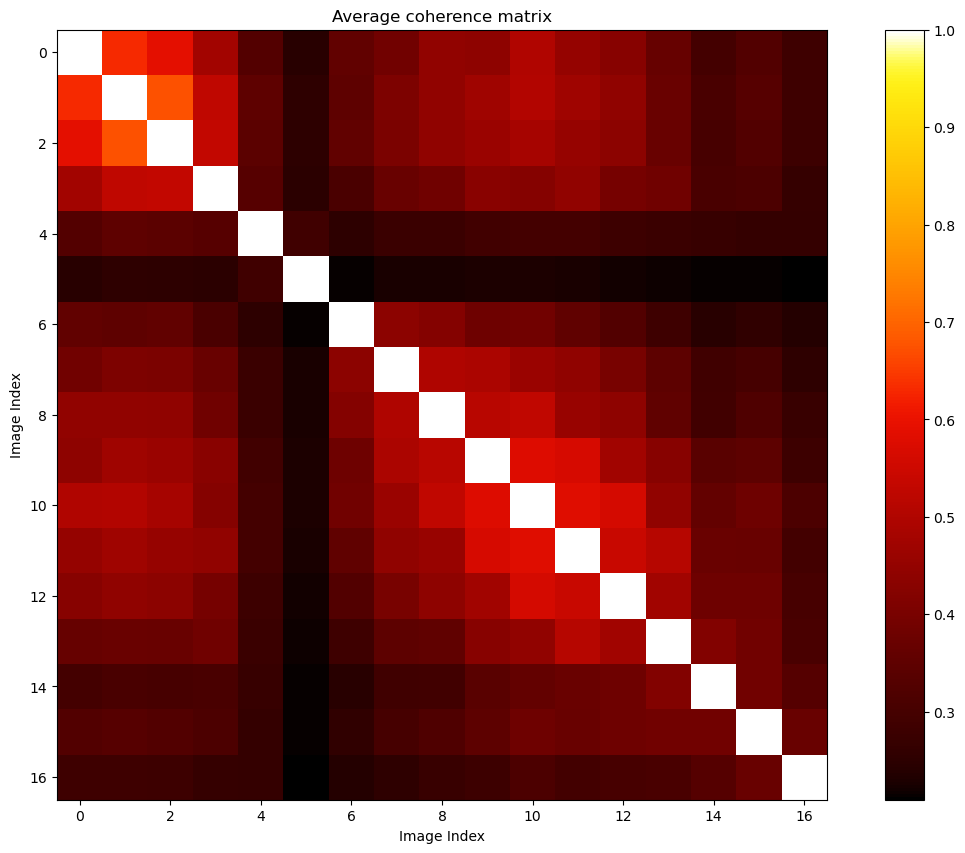

In [ ]:
ds_can_coh_ave_zarr = zarr.open(ds_can_coh_ave,'r')
fig, ax = plt.subplots(1,1,figsize=(15,10))
pcm = ax.imshow(ds_can_coh_ave_zarr[:],cmap=colorcet.cm.fire)
ax.set(title='Average coherence matrix',xlabel='Image Index',ylabel='Image Index')
fig.colorbar(pcm)
fig.show()

In [ ]:
%%time
#| hide
# import numpy as np
# import zarr
# import cupy as cp
# import math
# from decorrelation.shp import ks_test
# rslc_zarr = zarr.open('./raw/rslc.zarr',mode='r')
# ds_can_is_shp_zarr = zarr.open('./shp/ds_can_is_shp.zarr','r')
# ds_can_idx_zarr = zarr.open('./shp/ds_can_idx.zarr','r')

# rslc_cpu = rslc_zarr[:]; rslc = cp.asarray(rslc_cpu)
# ds_can_is_shp_cpu = ds_can_is_shp_zarr[:]; ds_can_is_shp = cp.asarray(ds_can_is_shp_cpu)
# ds_can_idx_cpu = ds_can_idx_zarr[:]; ds_can_idx = cp.asarray(ds_can_idx_cpu)

# ds_can_coh = emperical_co_pc(rslc,ds_can_idx,ds_can_is_shp)[1]

# ds_can_coh_cpu = cp.asnumpy(ds_can_coh)
# nimage = rslc.shape[-1]
# ds_can_chunk_size = math.ceil(ds_can_coh.shape[0]/3)
# test_ds_can_coh_zarr = zarr.open('./co/test_ds_can_coh.zarr','w',shape=ds_can_coh_cpu.shape,chunks=(ds_can_chunk_size,nimage,nimage),dtype=ds_can_coh_cpu.dtype)
# test_ds_can_coh_zarr[:] = ds_can_coh_cpu

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 11.9 µs


In [ ]:
#| hide
# ds_can_coh_result = zarr.open('./co/ds_can_coh.zarr','r')[:]
# ds_can_coh_test = zarr.open('./co/test_ds_can_coh.zarr','r')[:]
# np.testing.assert_array_equal(ds_can_coh_cpu,ds_can_coh_result)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()